In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
import time
from pathlib import Path
import csv
import re
import random
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
trainPath="D:/asl/mediapipe/train"
valPath="D:/asl/mediapipe/val"
testPath="D:/asl/mediapipe/test"


## EDA

In [32]:
#count number of files
counts=[]
label=[]

for file in os.listdir(trainPath):
  filepath= os.path.join(trainPath, file)
  label.append(file)
  count=0
  for f in os.listdir(filepath):
    count+=1
  counts.append(count)
dict(zip(label, counts))

{'africa': 619,
 'after': 618,
 'again': 618,
 'ago': 618,
 'all day': 618,
 'and': 618,
 'bacon': 618,
 'baseball': 618,
 'because': 618,
 'beginning': 618,
 'benefit': 618,
 'birthday': 618,
 'camera': 618,
 'can': 618,
 'card': 618}

In [4]:
counts=[]
label=[]

for file in os.listdir(valPath):
  filepath= os.path.join(valPath, file)
  label.append(file)
  count=0
  for f in os.listdir(filepath):
    count+=1
  counts.append(count)
dict(zip(label, counts))

{'africa': 96,
 'after': 96,
 'again': 96,
 'ago': 96,
 'all day': 96,
 'and': 96,
 'bacon': 96,
 'baseball': 96,
 'because': 96,
 'beginning': 96,
 'benefit': 96,
 'birthday': 96,
 'camera': 96,
 'can': 96,
 'card': 96}

In [5]:
counts=[]
label=[]

for file in os.listdir(testPath):
  filepath= os.path.join(testPath, file)
  label.append(file)
  count=0
  for f in os.listdir(filepath):
    count+=1
  counts.append(count)
dict(zip(label, counts))

{'africa': 1,
 'after': 1,
 'again': 1,
 'ago': 1,
 'all day': 1,
 'and': 1,
 'bacon': 1,
 'baseball': 1,
 'because': 1,
 'beginning': 1,
 'benefit': 1,
 'birthday': 1,
 'camera': 1,
 'can': 1,
 'card': 1}

## Frame Generator

In [6]:
def format_frames(frame, output_size):
  """
  convert RGB to single channel, pad and resize frames

  Args:
  frame: image that needs to be formated
  output_size: target pixel size of the output frame image

  Return:
  Formatted frame with padding of specified output size
  """
    frame= tf.image.convert_image_dtype(frame, tf.float32)
    frame= tf.image.resize_with_pad(frame, *output_size)
    frame= tf.image.rgb_to_grayscale(frame)

    return frame

In [8]:
def frames_from_video_file(video_path, n_frames, output_size, frame_step = 12):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(video_path)

  # video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  # need_length = 1 + (n_frames - 1) * frame_step

  # if need_length > video_length:
  #   start = 0
  # else:
  #   max_start = video_length - need_length
  #   start = random.randint(0, max_start + 1)

  # src.set(cv2.CAP_PROP_POS_FRAMES, start)
    src.set(cv2.CAP_PROP_POS_MSEC, 500)
  # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()

    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
            if ret:
                normframe = frame / 255.0
                normframe = format_frames(normframe, output_size)
            result.append(normframe)
            else:
                result.append(np.zeros_like(result[0]))
        src.release()
        result = np.array(result)[..., [0]]

    return result

6


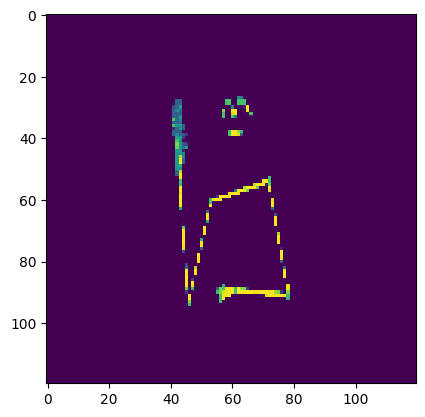

6


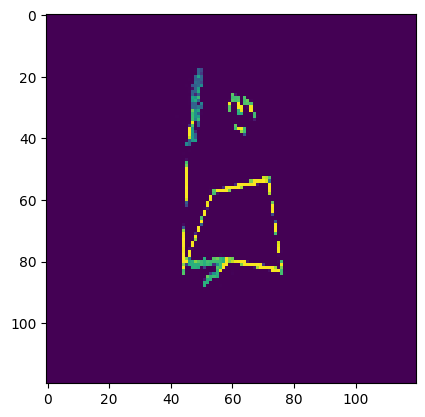

6


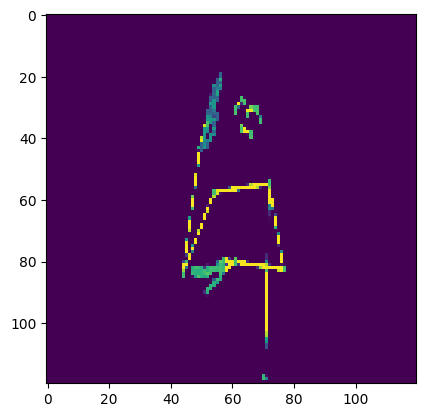

6


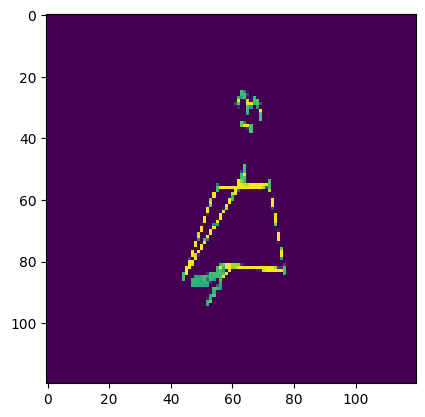

6


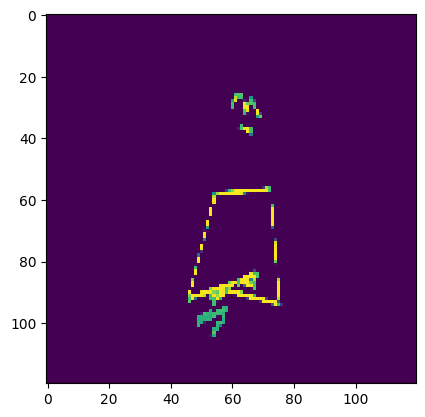

6


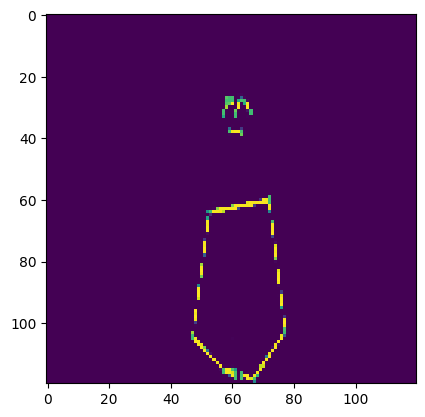

In [7]:
from matplotlib import pyplot as plt
for i in range(len(test)):
  print(len(test))
  plt.imshow(test[i], interpolation='nearest')
  plt. grid(False)
  plt.show()

6


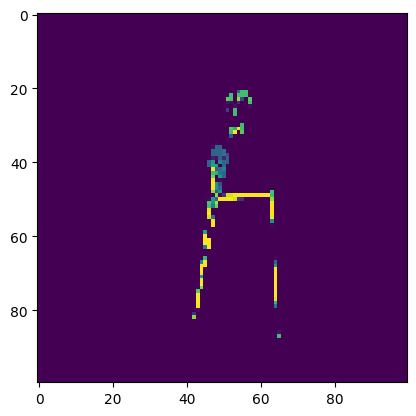

6


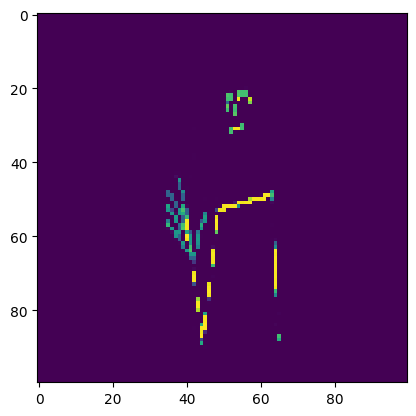

6


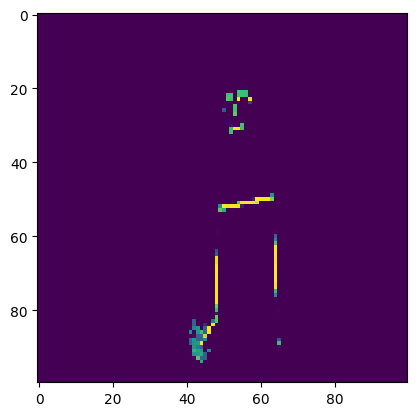

6


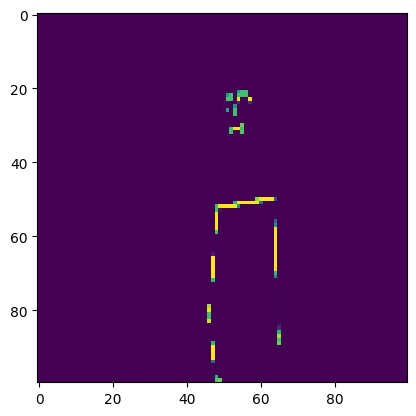

6


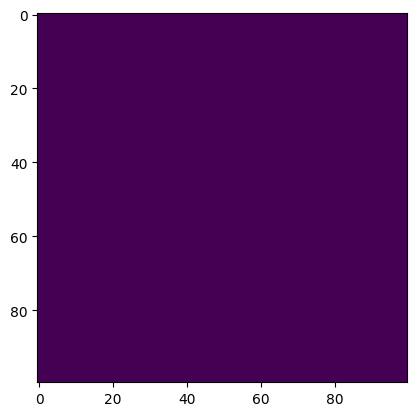

6


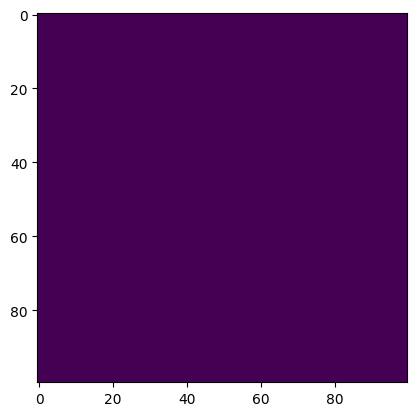

In [ ]:
from matplotlib import pyplot as plt
for i in range(len(test)):
  print(len(test))
  plt.imshow(test[i], interpolation='nearest')
  plt. grid(False)
  plt.show()

In [14]:
HEIGHT=100
WIDTH=100
n_frames=6
frame_step=8

In [9]:
class Frame_Generator:
    
    def __init__(self, folderPath, class_ids, n_frames, output_size, shuffle=False):

      """ Returns a set of frames with associated label.

      Args:
        path= video file paths
        n_frames= number of frames
        training: boolean to determine if dataset is being created.
      """
        self.folderPath= folderPath
        self.class_ids= class_ids
        self.n_frames= n_frames
        self.shuffle= shuffle
        self.output_size= output_size

    def get_files_and_class_names(self):
        video_paths= []
        classes=[]
        for folder in os.listdir(self.folderPath):
            folder_path= self.folderPath+"/"+folder
            for f in os.listdir(folder_path):
                if f.endswith('mp4'):
                    tag=f.split("_")[0]
                    classes.append(tag)
                    file_p= self.folderPath+"/"+folder+"/"+f
                    video_paths.append(file_p)
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.shuffle:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames= frames_from_video_file(path, self.n_frames, self.output_size)
            label= self.class_ids[name]
        yield video_frames, label


In [10]:
#generate labels
glossLst=[]
for file in os.listdir(trainPath):
    glossLst.append(file)
glossLst= sorted(glossLst)
glossLst

['africa',
 'after',
 'again',
 'ago',
 'all day',
 'and',
 'bacon',
 'baseball',
 'because',
 'beginning',
 'benefit',
 'birthday',
 'camera',
 'can',
 'card']

In [11]:
import tensorflow as tf

#perform one-hot encoding in glosses
idxarray=tf.keras.utils.to_categorical([i for i in range(len(glossLst))], num_classes=15)
class_ids=dict(zip(glossLst, idxarray))

In [12]:
glossLst= sorted(glossLst)
print(f'Total of {len(glossLst)} gloss in the dataset.')

Total of 15 gloss in the dataset.


In [15]:
fg = Frame_Generator(folderPath=trainPath,
                     class_ids= class_ids, n_frames=n_frames, output_size=(100, 100),shuffle=False)
frames, label= next(fg())


print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (6, 100, 100, 1)
Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (15,), dtype = tf.float32))
train_ds = tf.data.Dataset.from_generator(Frame_Generator(folderPath=trainPath,
                                                          class_ids=class_ids, n_frames=n_frames, output_size=(WIDTH, HEIGHT), shuffle=True),
                                          output_signature = output_signature)

In [17]:
# Create the validation set
output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (15, ), dtype = tf.float32))
val_ds = tf.data.Dataset.from_generator(Frame_Generator(folderPath=valPath,
                                                        class_ids=class_ids, n_frames=n_frames, output_size=(WIDTH, HEIGHT),shuffle=True),
                                        output_signature = output_signature)

In [18]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (6, 100, 100, 1)
Shape of training labels: (15,)
Shape of validation set of frames: (6, 100, 100, 1)
Shape of validation labels: (15,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [20]:
train_ds = train_ds.batch(32)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

Shape of training set of frames: (32, 6, 100, 100, 1)
Shape of training labels: (32, 15)


In [21]:
val_ds = val_ds.batch(32)

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of validation set of frames: (32, 6, 100, 100, 1)
Shape of validation labels: (32, 15)


In [22]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = (15,), dtype = tf.float32))
test_ds = tf.data.Dataset.from_generator(Frame_Generator(folderPath=testPath,
                                                          class_ids=class_ids, n_frames=n_frames, output_size=(WIDTH, HEIGHT), shuffle=True),
                                          output_signature = output_signature)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [24]:
test_ds = test_ds.batch(32)

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Shape of validation set of frames: (15, 6, 100, 100, 1)
Shape of validation labels: (15, 15)


## Model- Conv-GRU

In [25]:
import keras
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=a131f6114e63aec7923ac2bfd2cd2c10d5dcc3c5cf4149b5ca3b08cd60298676
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
from tensorflow import keras
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Resizing, Activation, Input,Bidirectional,GRU, ReLU
from keras import models
from keras_self_attention import SeqSelfAttention
from keras import layers

input_shape = (None, 6, 100, 100, 1)
input = Input(shape=(input_shape[1:]))
x = input
x = Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
shape = keras.backend.int_shape(x)
x= layers.Reshape((shape[1],shape[-3]*shape[-2]*shape[-1]))(x)
x = layers.GRU(4, return_sequences=True, dropout=0.3)(x)
x=  SeqSelfAttention(attention_width=15,attention_activation='sigmoid',
                     kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.Flatten()(x)
x = layers.Dense(15, activation='softmax')(x)

model = keras.Model(input, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 100, 100, 1)]  0         
                                                                 
 conv3d_2 (Conv3D)           (None, 6, 100, 100, 32)   896       
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 re_lu_2 (ReLU)              (None, 6, 50, 50, 32)     0         
                                                                 
 dropout_2 (Dropout)         (None, 6, 50, 50, 32)     0         
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 50, 50, 64)     55360     
                                                           

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=0.8)


In [ ]:
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [ ]:
gru_result = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=[callback])

Epoch 1/20
290/290 [==============================] - 4159s 13s/step - loss: 1.6024 - accuracy: 0.5461 - val_loss: 2.9526 - val_accuracy: 0.1882
Epoch 2/20
290/290 [==============================] - 3181s 11s/step - loss: 0.6198 - accuracy: 0.8891 - val_loss: 3.6602 - val_accuracy: 0.1743
Epoch 3/20
290/290 [==============================] - 3181s 11s/step - loss: 0.3278 - accuracy: 0.9584 - val_loss: 4.4170 - val_accuracy: 0.1722
Epoch 4/20
290/290 [==============================] - 3200s 11s/step - loss: 0.1997 - accuracy: 0.9770 - val_loss: 4.9769 - val_accuracy: 0.1764
Epoch 5/20
290/290 [==============================] - 3206s 11s/step - loss: 0.1317 - accuracy: 0.9852 - val_loss: 5.2350 - val_accuracy: 0.1882
Epoch 6/20
290/290 [==============================] - 3238s 11s/step - loss: 0.1147 - accuracy: 0.9825 - val_loss: 5.4963 - val_accuracy: 0.1792
Epoch 7/20
290/290 [==============================] - 3482s 12s/step - loss: 0.0829 - accuracy: 0.9886 - val_loss: 5.8305 - val_ac

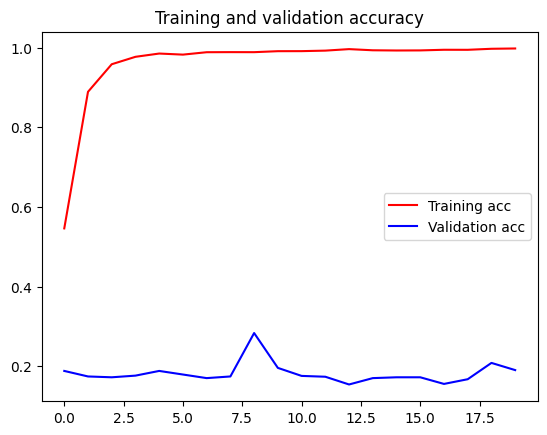

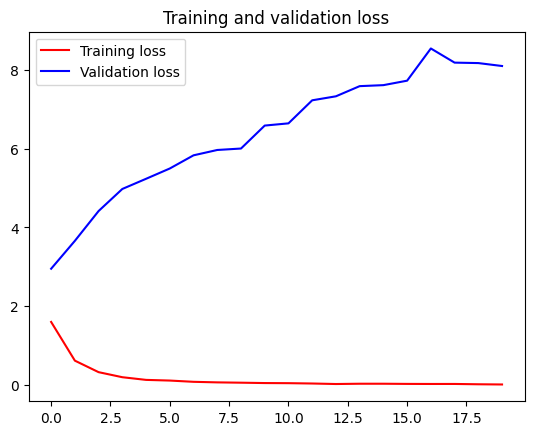

In [ ]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = gru_result .history['accuracy']
val_acc = gru_result .history['val_accuracy']
loss = gru_result .history['loss']
val_loss = gru_result .history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Capstone /asl/gru.h5')

In [ ]:
#evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)

1/1 [==============================] - 0s 147ms/step - loss: 7.2542 - accuracy: 0.1333


In [ ]:
true_labels = np.argmax(test_labels, axis=1)
true_labels

array([ 5,  6, 12, 13,  1, 10,  8,  0,  4,  7, 14, 11,  2,  9,  3])

In [ ]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

1/1 [==============================] - 0s 97ms/step


array([ 0,  8,  2, 13,  6,  3,  3,  0,  9,  3, 10,  5])

In [ ]:
#confusion matrix
# Make predictions on the test data
predictions = model.predict(test_frames)
predictions
# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

1/1 [==============================] - 0s 114ms/step


array([ 3,  0, 11,  2,  2, 13,  8,  3, 10,  0,  6,  6,  3,  9,  5])

In [ ]:
from sklearn.metrics import confusion_matrix

# from sklearn.metrics import confusion_matrix
confusion_gru = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_gru)

Confusion Matrix:
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


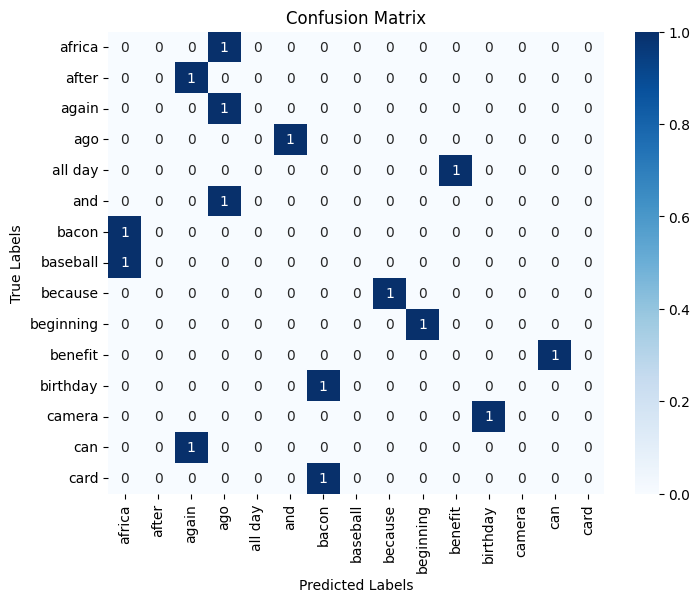

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_gru, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

      africa       0.00      0.00      0.00         1
       after       0.00      0.00      0.00         1
       again       0.00      0.00      0.00         1
         ago       0.00      0.00      0.00         1
     all day       0.00      0.00      0.00         1
         and       0.00      0.00      0.00         1
       bacon       0.00      0.00      0.00         1
    baseball       0.00      0.00      0.00         1
     because       1.00      1.00      1.00         1
   beginning       1.00      1.00      1.00         1
     benefit       0.00      0.00      0.00         1
    birthday       0.00      0.00      0.00         1
      camera       0.00      0.00      0.00         1
         can       0.00      0.00      0.00         1
        card       0.00      0.00      0.00         1

    accuracy                           0.13        15
   macro avg       0.13      0.13      0.13        15
weighted avg       0.13   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Conv-LSTM

In [29]:
from tensorflow import keras
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Resizing, Activation, Input,Bidirectional,GRU, ReLU
from keras import models
from keras_self_attention import SeqSelfAttention
from keras import layers

input_shape = (None, 6, 100, 100, 1)
input = Input(shape=(input_shape[1:]))
x = input
x = Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same')(x)
x = MaxPooling3D((1,2,2))(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
shape = keras.backend.int_shape(x)
x= layers.Reshape((shape[1],shape[-3]*shape[-2]*shape[-1]))(x)
x = layers.LSTM(4, return_sequences=True, dropout=0.3)(x)
x=  SeqSelfAttention(attention_width=15,attention_activation='sigmoid',
                     kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.Flatten()(x)
x = layers.Dense(15, activation='softmax')(x)

model = keras.Model(input, x)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 100, 100, 1)   0         
                             ]                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 6, 100, 100, 32)   896       
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 6, 50, 50, 32)     0         
 g3D)                                                            
                                                                 
 re_lu_2 (ReLU)              (None, 6, 50, 50, 32)     0         
                                                                 
 dropout_2 (Dropout)         (None, 6, 50, 50, 32)     0         
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 50, 50, 64)     5536

In [30]:
model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [33]:
lstm_result = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/20
30/30 [==============================] - 430s 15s/step - loss: 2.5829 - accuracy: 0.1249 - val_loss: 2.6348 - val_accuracy: 0.2417
Epoch 2/20
30/30 [==============================] - 198s 7s/step - loss: 2.3011 - accuracy: 0.2434 - val_loss: 2.7005 - val_accuracy: 0.1708
Epoch 3/20
30/30 [==============================] - 193s 6s/step - loss: 2.1081 - accuracy: 0.3206 - val_loss: 2.8374 - val_accuracy: 0.1410
Epoch 4/20
30/30 [==============================] - 201s 7s/step - loss: 1.9160 - accuracy: 0.4074 - val_loss: 2.8403 - val_accuracy: 0.1299
Epoch 5/20
30/30 [==============================] - 194s 6s/step - loss: 1.7201 - accuracy: 0.4751 - val_loss: 2.9954 - val_accuracy: 0.1722
Epoch 6/20
30/30 [==============================] - 194s 6s/step - loss: 1.5012 - accuracy: 0.6286 - val_loss: 3.0417 - val_accuracy: 0.1250
Epoch 7/20
30/30 [==============================] - 190s 6s/step - loss: 1.3693 - accuracy: 0.6783 - val_loss: 3.1767 - val_accuracy: 0.1361
Epoch 8/20
3

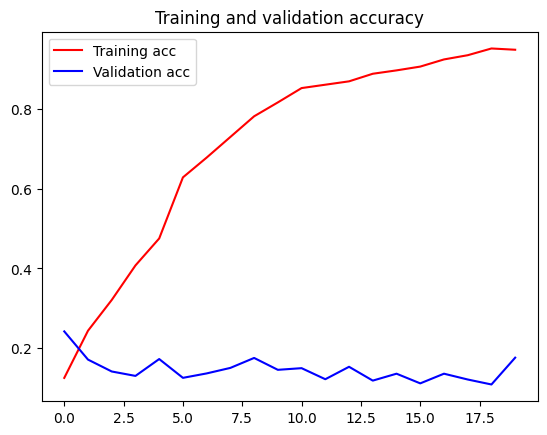

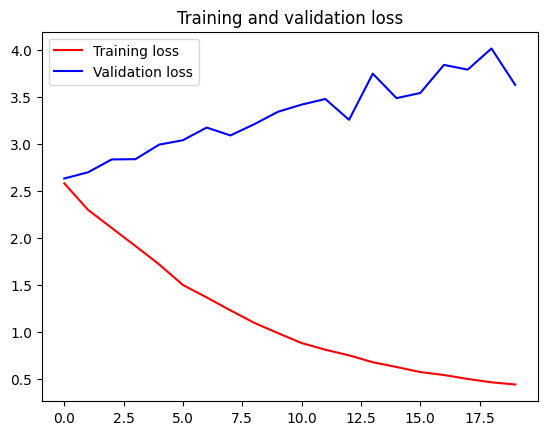

In [35]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = gru_result .history['accuracy']
val_acc = gru_result .history['val_accuracy']
loss = gru_result .history['loss']
val_loss = gru_result .history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
#evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)

1/1 [==============================] - 0s 236ms/step - loss: 4.2496 - accuracy: 0.2000


In [37]:
true_labels = np.argmax(test_labels, axis=1)
true_labels

array([ 2, 12, 11,  5,  7,  1,  3, 10,  4, 14,  0,  6,  9,  8, 13],
      dtype=int64)

In [38]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

1/1 [==============================] - 3s 3s/step


array([ 5,  3, 11,  3,  1, 12, 13,  3, 14, 13,  3,  7,  9, 14, 13],
      dtype=int64)

In [39]:
from sklearn.metrics import confusion_matrix

# from sklearn.metrics import confusion_matrix
confusion_gru = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_gru)

Confusion Matrix:
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


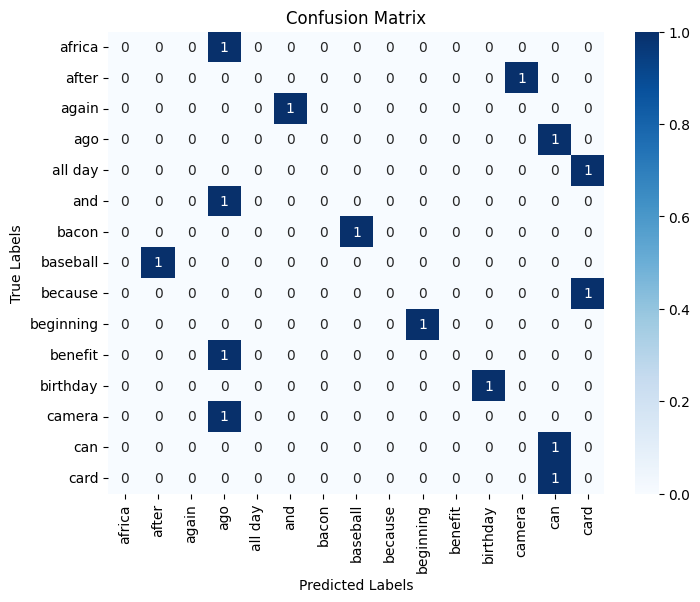

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_gru, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

      africa       0.00      0.00      0.00         1
       after       0.00      0.00      0.00         1
       again       0.00      0.00      0.00         1
         ago       0.00      0.00      0.00         1
     all day       0.00      0.00      0.00         1
         and       0.00      0.00      0.00         1
       bacon       0.00      0.00      0.00         1
    baseball       0.00      0.00      0.00         1
     because       0.00      0.00      0.00         1
   beginning       1.00      1.00      1.00         1
     benefit       0.00      0.00      0.00         1
    birthday       1.00      1.00      1.00         1
      camera       0.00      0.00      0.00         1
         can       0.33      1.00      0.50         1
        card       0.00      0.00      0.00         1

    accuracy                           0.20        15
   macro avg       0.16      0.20      0.17        15
weighted avg       0.16   

C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TSL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
